In [1]:
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
 
warnings.filterwarnings(action = 'ignore')
 
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import sklearn.metrics as skm
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from keras.models import Sequential
from keras.layers import Dense, LSTM,Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mkepa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mkepa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return words

In [3]:
def feature_vector(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    num_words = 0
    index2word_set = set(model.wv.index_to_key)
    
    for word in words:
        if word in index2word_set:
            num_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if num_words > 0:
        feature_vector = np.divide(feature_vector, num_words)
    
    return feature_vector

In [4]:
def encode(category):
    if category=='true':
        category=1
    else:
        category=0
    return category    

In [5]:
def get_models():
    models = dict()
    for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
        
        key = '%.4f' % p
      
        if p == 0.0:
            # no penalty in this case
            models[key] = LogisticRegression(solver='lbfgs', penalty='none')
        else:
            models[key] = LogisticRegression(solver='lbfgs', penalty='l2', C=p)
    return models

In [6]:
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [7]:
data_fake=pd.read_csv('C:/Users/mkepa/Downloads/Fake/Fake.csv')

In [8]:
data_true=pd.read_csv('C:/Users/mkepa/Downloads/True/True.csv')

In [9]:
data_fake[data_fake['text']==' '].count()

title      626
text       626
subject    626
date       626
dtype: int64

In [10]:
data_fake=data_fake[data_fake['text']!=' ']

In [11]:
data_true=data_true[data_true['text']!=' ']

In [12]:
data_fake["label"]="fake"

In [13]:
data_true["label"]="true"

In [14]:
data=pd.concat([data_fake,data_true], ignore_index=True)

In [ ]:
'data.to_excel('C:/Users/mkepa/Downloads/data.xlsx')

In [5]:
'data=pd.read_excel('C:/Users/mkepa/Downloads/data.xlsx')

In [15]:
text = ' '.join(data['text'])

In [16]:
tokens=preprocess_text(text)

In [39]:
word_counts = Counter(tokens)

In [44]:
frequencies = sorted(word_counts.values(), reverse=True)

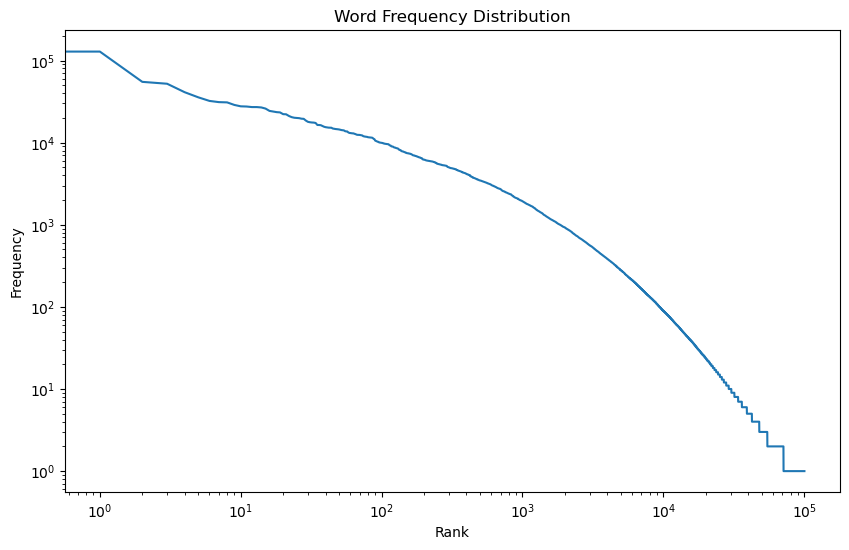

In [8]:
plt.figure(figsize=(10, 6))
plt.loglog(frequencies)  # Log-log plot to better visualize the distribution
plt.title('Word Frequency Distribution')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

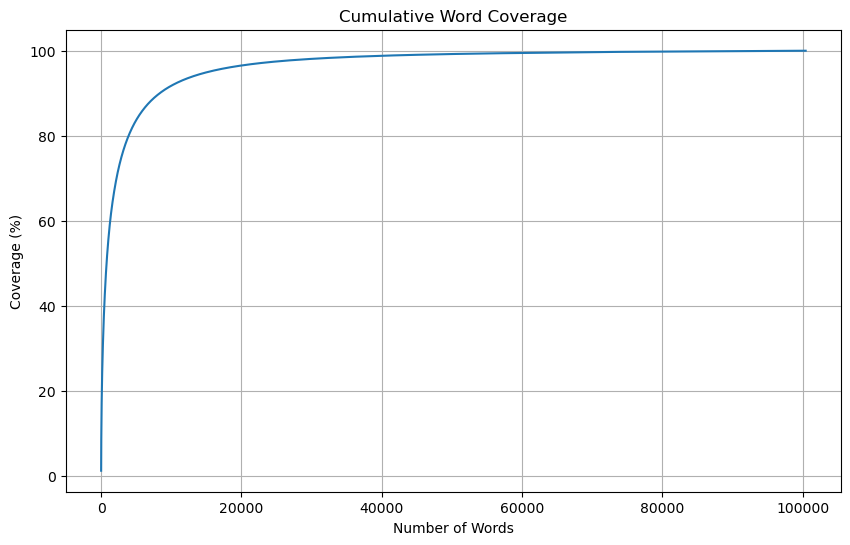

In [9]:
cumulative_frequencies = np.cumsum(frequencies)
total_words = cumulative_frequencies[-1]
coverage = cumulative_frequencies / total_words * 100

# Plot cumulative coverage
plt.figure(figsize=(10, 6))
plt.plot(coverage)
plt.title('Cumulative Word Coverage')
plt.xlabel('Number of Words')
plt.ylabel('Coverage (%)')
plt.grid(True)
plt.show()

In [10]:
coverage[60000] # 60000 out of 100 000 words covers 99% of number of words in my vocubulary

99.47543821165206

In [20]:
tqdm.pandas()

In [21]:
data['tokens'] = data['text'].progress_apply(preprocess_text)

100%|███████████████████████████████████████████████████████████████████████████| 44271/44271 [03:10<00:00, 232.81it/s]


In [22]:
model1= gensim.models.Word2Vec(sentences=data['tokens'], min_count = 5, 
                              vector_size = 5, window = 5)

In [23]:
data['word2vec_features'] = data['tokens'].progress_apply(lambda x: feature_vector(x, model1, 5))

100%|████████████████████████████████████████████████████████████████████████████| 44271/44271 [07:34<00:00, 97.36it/s]


In [50]:
data.drop(['title','text','subject','date','tokens'],inplace=True, axis=1)

In [51]:
data['label'].value_counts()

label
fake    22855
true    21416
Name: count, dtype: int64

In [25]:
data['New_label']=data['label'].apply(lambda x: encode(x))

In [26]:
data.drop(['label'],inplace=True, axis=1)

In [35]:
X=list(data['word2vec_features'])

In [24]:
y=data['New_label']

In [ ]:
models = get_models()
results, names = list(), list()

In [37]:
for name, model in models.items():
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize progress along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison


>0.0000 0.838 (0.005)
>0.0001 0.835 (0.006)
>0.0010 0.837 (0.006)
>0.0100 0.837 (0.005)
>0.1000 0.838 (0.005)
>1.0000 0.838 (0.005)


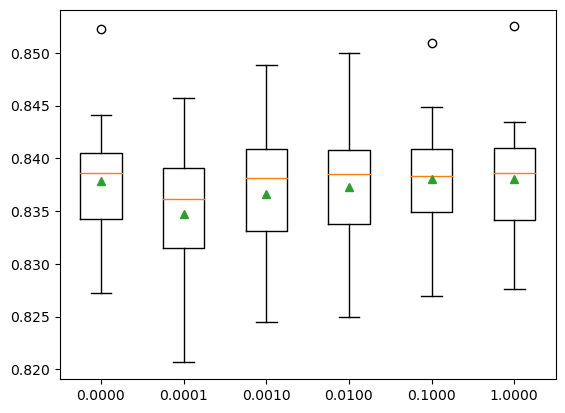

In [38]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
model=LogisticRegression(solver='lbfgs', penalty='none',max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='none')

In [43]:
predictions=model.predict(X_test)

In [44]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      6913
           1       0.83      0.84      0.84      6369

    accuracy                           0.84     13282
   macro avg       0.84      0.84      0.84     13282
weighted avg       0.84      0.84      0.84     13282



In [45]:
confusion_matrix(y_test,predictions)

array([[5809, 1104],
       [ 993, 5376]], dtype=int64)

In [64]:
check=pd.DataFrame(y_test)

In [71]:
check['New_label'].value_counts()

New_label
0    6913
1    6369
Name: count, dtype: int64

In [49]:
logr_probs=model.predict_proba(X_test)

In [52]:
logr_probs0 = logr_probs[:,0]
logr_probs1=logr_probs[:,1]

In [54]:
precision0, recall0, _ = skm.precision_recall_curve(y_test,logr_probs0,pos_label=0)
precision1, recall1, _ = skm.precision_recall_curve(y_test,logr_probs1,pos_label=1)

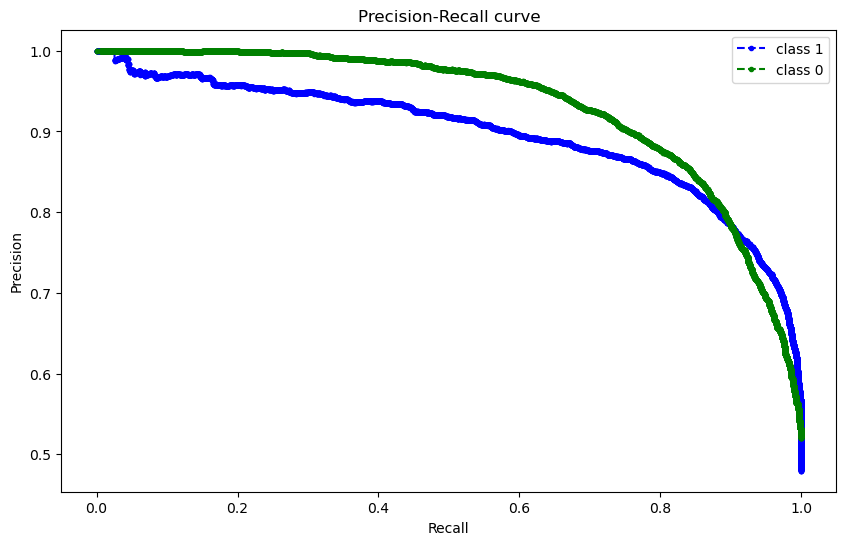

In [56]:
plt.figure(figsize=(10,6))
plt.plot(recall1, precision1,'b', label='class 1',linestyle='--',marker='.')
plt.plot(recall0, precision0,'g', label='class 0',linestyle='--',marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title("Precision-Recall curve")
plt.show()

In [58]:
logr_fpr0, logr_tpr0, _ = roc_curve(y_test, logr_probs0,pos_label=0)
logr_fpr1, logr_tpr1, _ = roc_curve(y_test, logr_probs1,pos_label=1)

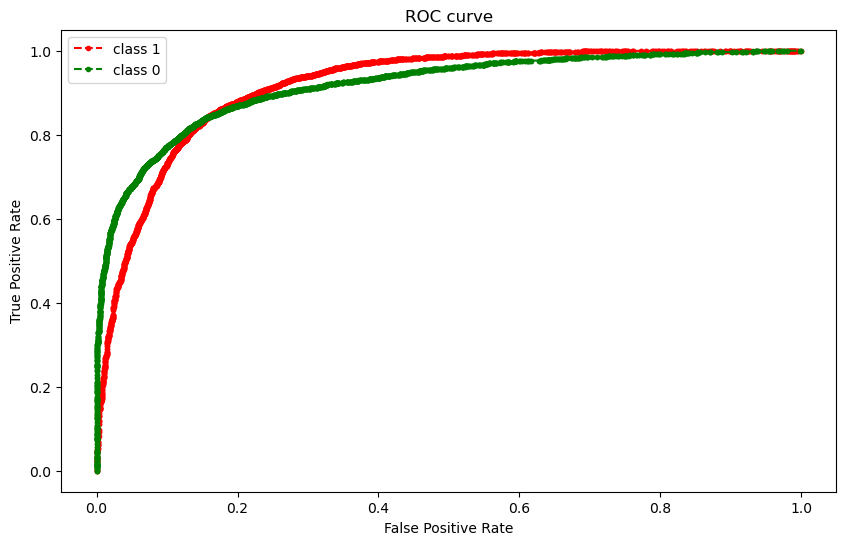

In [59]:
plt.figure(figsize=(10,6))
plt.plot(logr_fpr1, logr_tpr1,'r', label='class 1',linestyle='--',marker='.')
plt.plot(logr_fpr0, logr_tpr0,'g', label='class 0',linestyle='--',marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title("ROC curve")
plt.show()

In [17]:
tokenizer = Tokenizer()

In [18]:
tokenizer.fit_on_texts(tokens)

In [22]:
data['text_int'] = data['tokens'].progress_apply(lambda x: tokenizer.texts_to_sequences([x])[0])

100%|██████████████████████████████████████████████████████████████████████████| 44271/44271 [00:05<00:00, 7838.22it/s]


In [23]:
X=list(data['text_int'])

In [27]:
y=data['New_label']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [29]:
lista=[]##checking average lenght of tokens in one tweet
for index, row in data.iterrows():
    lista.append(len(row['tokens']))
    

In [30]:
max_review_length=round(sum(lista)/len(lista))
print(max_review_length)

223


In [31]:
vocab_size = 100480+1
embedding_vector_length = 5

In [32]:
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [33]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(10))  # LSTM layer with 100 memory units
model.add(Dense(1, activation='sigmoid'))  # Output layer

In [34]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Epoch 1/3


485/485 [==============================] - 52s 85ms/step - loss: 0.3025 - accuracy: 0.8744 - val_loss: 0.1046 - val_accuracy: 0.9721
Epoch 2/3
485/485 [==============================] - 37s 76ms/step - loss: 0.0740 - accuracy: 0.9794 - val_loss: 0.0870 - val_accuracy: 0.9711
Epoch 3/3
485/485 [==============================] - 37s 76ms/step - loss: 0.0462 - accuracy: 0.9871 - val_loss: 0.0663 - val_accuracy: 0.9776


In [81]:
loss_df=pd.DataFrame(model.history.history)

<Axes: >

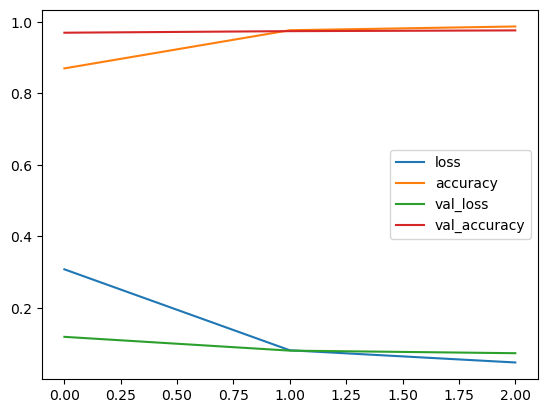

In [82]:
loss_df.plot()

In [36]:
test_predictions=model.predict(X_test)

416/416 [==============================] - 13s 16ms/step


In [71]:
test_predictions_0=[]

In [73]:
for i in test_predictions:
    test_predictions_0.append(1-i)
    

In [39]:
min(test_predictions)

array([0.0011894], dtype=float32)

In [40]:
type(test_predictions)

numpy.ndarray

In [49]:
forecasts=[]

In [50]:
for x in test_predictions:
    
    if x<0.5:
        forecasts.append(0)
    else:
        forecasts.append(1)

In [52]:
print(classification_report(y_test,forecasts))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6913
           1       0.97      0.98      0.98      6369

    accuracy                           0.98     13282
   macro avg       0.98      0.98      0.98     13282
weighted avg       0.98      0.98      0.98     13282



In [79]:
precision1, recall1, threshold = skm.precision_recall_curve(y_test,test_predictions,pos_label=1)
precision0, recall0, _ = skm.precision_recall_curve(y_test,test_predictions_0,pos_label=0)

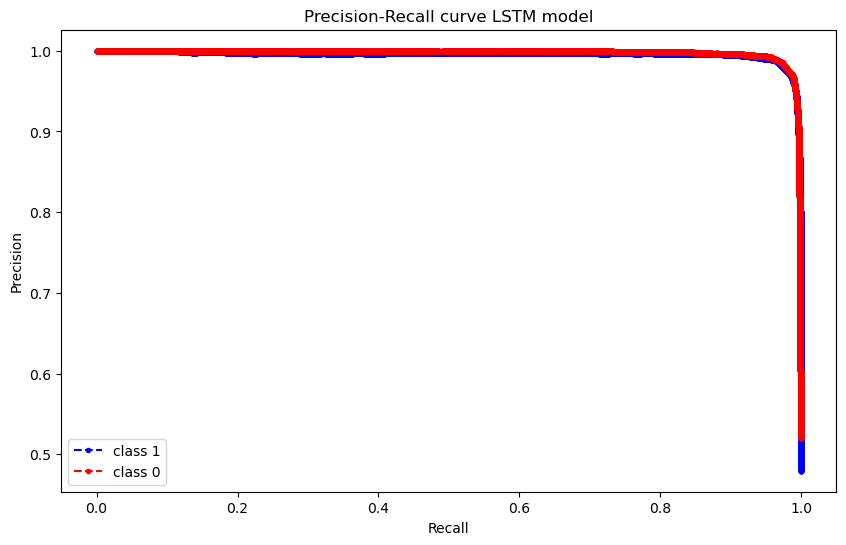

In [78]:
plt.figure(figsize=(10,6))
plt.plot(recall1, precision1,'b', label='class 1',linestyle='--',marker='.')
plt.plot(recall0, precision0,'r', label='class 0',linestyle='--',marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title("Precision-Recall curve LSTM model")
plt.show()

In [83]:
model.save('C:/Users/mkepa/Downloads/LSTM_model')

INFO:tensorflow:Assets written to: C:/Users/mkepa/Downloads/LSTM_model\assets


INFO:tensorflow:Assets written to: C:/Users/mkepa/Downloads/LSTM_model\assets
